# Isotopically steady state 13C MFA
## License information
The data and model used in this notebook comes from 

Alagesan, S., Minton, N.P. & Malys, N. 13C-assisted metabolic flux analysis to investigate heterotrophic and mixotrophic metabolism in Cupriavidus necator H16. Metabolomics 14, 9 (2018). https://doi.org/10.1007/s11306-017-1302-z 

and is licensed under a Creative Commons Attribution 4.0 International License.

You should have received a copy of the license along with this
work. If not, see <http://creativecommons.org/licenses/by/4.0/>.

## Description of data
Alagesan and their colleagues aims to investigate the difference between heterotrophic and mixotrophic metabolism in Cupriavidus necator H16. They setup of three experimental condition differing in the available carbon sources. Two heterotrophic growth conditions using either [1-13C]fructose, or [1,2-13C]Glycerol as the sole carbon source and one mixotrophic condition using a mix of [1,2-13C]Glycerol and unlabelled CO2 as carbon source. All cultures are growth as batch cultures and samples were drawn during exponential growth phase.

In [1]:
import pandas as pd
import numpy as np
import dotenv
import ast
import pandera as pa
import incawrapper
from incawrapper import run_inca
from incawrapper import utils
from incawrapper import visualization

In [2]:
# import environment variables
INCA_base_directory = dotenv.get_key(dotenv.find_dotenv(), "INCA_base_directory")

## Importing and processing data
We will try to make this tutorial as realistic as possible, therefore we will also include some data preprocessing to show case an example of how to get the data into the correct format. We have taken the data from the supplementary materials from the article described above. The actual supplementary materials is a word document, therefore we manually extracted the data into a series of csv and excel files.

### Reaction data
As a beginning we will have a look at the reactions and atom map from the article.

In [3]:
reacts = pd.read_excel("./Literature data/Cupriavidus necator  Alagesan 2017/reactions.xlsx")
reacts

,Reaction ID,Equations (Carbon atom transition)
0,ex_1,FRU.ext (abcdef) -> F6P (abcdef)
1,ex_2,GLY.ext (abc) -> GLY (abc)
2,R1,GLY (abc) -> DHAP (abc)
3,R2,F6P (abcdef) -> G6P (abcdef)
4,R3,G6P (abcdef) -> F6P (abcdef)
...,...,...
69,R68,ANTHR (abcdefg) + R5P (hijkl) -> CPADR5P (abcd...
70,R69,CPADR5P (abcdefghijkl) -> INDG (abcdfghijkl) +...
71,R70,INDG (abcdfghijkl) -> TRP (abcdfghijkl)
72,R71,R5P (abcde) + MTHF (f)-> HIS (edcbaf)


We see that the model contains 74 reaction. The incawrapper uses the package Pandera to validate the input data. We can check if the reaction data correctly formatted according to the `ReactionsSchema`. We will wrap it in a try-except clause to create an output that is easier to interpret.

In [4]:
try:
    incawrapper.ReactionsSchema.validate(reacts)
except pa.errors.SchemaError as e:
    print(type(e))
    print(e)

<class 'pandera.errors.SchemaError'>
column 'rxn_id' not in dataframe
  Reaction ID Equations (Carbon atom transition)
0        ex_1   FRU.ext (abcdef) -> F6P (abcdef)
1        ex_2         GLY.ext (abc) -> GLY (abc)
2          R1            GLY (abc) -> DHAP (abc)
3          R2       F6P (abcdef) -> G6P (abcdef)
4          R3       G6P (abcdef) -> F6P (abcdef)


We see that the schema does not pass the validation as a `SchemaError` is raised. Furthermore, Pandera informs us that the schema expects a column named `rxn_eqn` which is not found. Let's have a look at what are actually requirements for the model_reaction_schema.

In [5]:
utils.present_schema_overview(incawrapper.ReactionsSchema)

,column name,dtype,required,nullable,description
0,rxn_id,str,True,False,The unique id of the reaction
1,rxn_eqn,str,True,False,"The reaction equation with atom map. Allowed reaction arrows: ->, <->."


The `ReactionsSchema` requires two columns `rxn_eqn` and `rxn_id`. Let's rename the columns of the reactions data and rerun the validation.

In [6]:
reacts_renamed = (reacts
    .copy()
    .rename(columns={"Reaction ID": "rxn_id", "Equations (Carbon atom transition)":"rxn_eqn"})
)
incawrapper.ReactionsSchema.validate(reacts_renamed)
reacts_renamed

,rxn_id,rxn_eqn
0,ex_1,FRU.ext (abcdef) -> F6P (abcdef)
1,ex_2,GLY.ext (abc) -> GLY (abc)
2,R1,GLY (abc) -> DHAP (abc)
3,R2,F6P (abcdef) -> G6P (abcdef)
4,R3,G6P (abcdef) -> F6P (abcdef)
...,...,...
69,R68,ANTHR (abcdefg) + R5P (hijkl) -> CPADR5P (abcd...
70,R69,CPADR5P (abcdefghijkl) -> INDG (abcdfghijkl) +...
71,R70,INDG (abcdfghijkl) -> TRP (abcdfghijkl)
72,R71,R5P (abcde) + MTHF (f)-> HIS (edcbaf)


The reactions data passed the validation. We also notice that some reactions are the reverse of one anther, look at reaction R2 and R3 above. This is not a problem, but the often we are mainly interested in the net reaction. To avoid calculating the net reactions after the analysis, we will merge the reactions into one reversible reaction. The utils module has a small function called the `merge_reversible_reaction`.

In [7]:
reacts_merged = utils.merge_reaverible_reaction(reacts_renamed)
reacts_merged.head()

Found inverse reaction: F6P (abcdef) -> G6P (abcdef) and G6P (abcdef) -> F6P (abcdef)
Found inverse reaction: F16P (abcdef) -> DHAP (cba) + G3P (def) and DHAP (cba) + G3P (def) -> F16P (abcdef)
Found inverse reaction: DHAP (abc) -> G3P (abc) and G3P (abc) -> DHAP (abc)
Found inverse reaction: G3P (abc) -> 3PG (abc) and 3PG (abc) -> G3P (abc)
Found inverse reaction: 3PG (abc) -> PEP (abc) and PEP (abc) -> 3PG (abc)
Found inverse reaction: PEP (abc) -> PYR (abc) and PYR (abc) -> PEP (abc)
Found inverse reaction: CIT (abcdef) -> ISCIT (abcdef) and ISCIT (abcdef) -> CIT (abcdef)
Found inverse reaction: SUC (abcd) -> MAL (abcd) and MAL (abcd) -> SUC (abcd)
Found inverse reaction: MAL (abcd) -> OAA (abcd) and OAA (abcd) -> MAL (abcd)
Found inverse reaction: PEP (abc) + CO2 (d) -> OAA (abcd) and OAA (abcd) -> PEP (abc) + CO2 (d)
Found inverse reaction: RU5P (abcde) -> R5P (abcde) and R5P (abcde) -> RU5P (abcde)
Found inverse reaction: RU5P (abcde) -> X5P (abcde) and X5P (abcde) -> RU5P (abcde

,rxn_id,rxn_eqn
0,ex_1,FRU.ext (abcdef) -> F6P (abcdef)
1,ex_2,GLY.ext (abc) -> GLY (abc)
2,R1,GLY (abc) -> DHAP (abc)
3,R2,F6P (abcdef) <-> G6P (abcdef)
5,R4,F16P (abcdef) -> F6P (abcdef)


We see that several reactions were successfully merged. 

In [8]:
reacts_processed = reacts_merged.copy()

### Tracer information
Now, we are ready to define the tracers that is used for the different experiments. This information is lifted from the materials and methods. They used substrates with 99 atom% purity for both the D-[1-13C]fructose, and [1,2-13C]glycerol. For the mixotrophic growth experiment they use two substrate [1,2-13C]glycerol and CO2. We will assume that the CO2 is unlabelled, i.e. labelled with natural abundance. Therefore, we will not consider the CO2 in the tracer specification.

In [9]:
tracer_info = pd.DataFrame.from_dict({
    'experiment_id': [
        'fructose', 'glycerol', 'mixotroph',
    ],
    'met_id': ['FRU.ext', 'GLY.ext', 'GLY.ext'],
    'tracer_id': [
        'D-[1-13C]fructose', '[1,2-13C]glycerol', '[1,2-13C]glycerol',
    ],
    'atom_ids': [
        [1], [1,2], [1,2],
    ],
    'atom_mdv': [
        [0.01,0.99], [0.01,0.99],[0.01,0.99],
    ],
    'enrichment': [
        1, 1, 1,
    ]    
}, orient='columns')
tracer_info.head()

,experiment_id,met_id,tracer_id,atom_ids,atom_mdv,enrichment
0,fructose,FRU.ext,D-[1-13C]fructose,[1],"[0.01, 0.99]",1
1,glycerol,GLY.ext,"[1,2-13C]glycerol","[1, 2]","[0.01, 0.99]",1
2,mixotroph,GLY.ext,"[1,2-13C]glycerol","[1, 2]","[0.01, 0.99]",1


In [10]:
try:
    incawrapper.TracerSchema.validate(tracer_info)
except Exception as e:
    print(e)

The dataframe passed the validation, so we can move on to prepare the isopomer distribution vectors (idvs) also called the mass distribution vectors (mdvs). 

### MS measurements
We will first inspect the data schema to inspect the required data structure.

In [11]:
utils.present_schema_overview(incawrapper.MSMeasurementsSchema)


,column name,dtype,required,nullable,description
0,experiment_id,str,True,False,"ID of the experiment. Must be a valid MATLAB variable name, legal characters are a-z, A-Z, 0-9, and the underscore character."
1,met_id,str,True,False,Metabolite ID of metabolite which is directly measured or from which the fragment is derived through a derivatization method.
2,ms_id,str,True,False,ID of the measured ms fragment - often multiple fragment can be measured from the same metabolite
3,measurement_replicate,int64,True,False,"Replicate number of the measurement of the same fragment in the same experiment. \n""In most cases, the data will only have one measurement per fragment per experiment."
4,labelled_atom_ids,object,True,False,List of atom ids of the labelled atoms in the metabolite.
5,unlabelled_atoms,str,False,True,The molecular formula of the all atoms that cannot be labelled through \nthe introduced labels in the tracers. This typically includes non-carbon elements of the fragment and all elements originating from derivatization agent. \nINCA uses the unlabelled atoms to correct for natural abundance.
6,mass_isotope,int64,True,False,"The mass isotopomer of the fragment.\nE.g. M0, M+1, etc. Specified as an integer. It is allowed to have gaps in the isotopmer of a given fragment, e.g. 0, 2, 3. In this case the intensity and \nstd error of missing isotopomers are filled with NaN before inserted in INCA."
7,intensity,float64,True,True,The measured intensity of the fragment mass isotope.
8,intensity_std_error,float64,True,True,The standard error of the measured intensity of the fragment mass isotope.
9,time,float64,True,False,Time point of measurement only relevant for isotopically non-stationary MFA analysis


This provides a overview of which columns are required. Next, we load the MS data set from the article. We have copied the tables from the word document into an excel-workbook with three sheets one for each experiment (Fructose, Glycerol, GlycerolAndCO2). Lets have a look at the content of one of the sheets:

In [12]:
pd.read_excel("Literature data/Cupriavidus necator  Alagesan 2017/MDV_raw.xlsx", sheet_name='fructose').head()

,Amino Acid,Unnamed: 1,m/z,M,M+1,M+2,M+3,M+4,M+5,M+6,M+7,M+8,M+9
0,Alanine,[M-85],232,0.9759 ± 0.0027,0.0230 ± 0.0035,0.0011 ± 0.0009,0,0,0,0,0,0,0
1,NaN,[M-57],260,0.3509 ± 0.0135,0.6407 ± 0.0138,0.0078 ± 0.0003,0.0006 ± 0.0006,0,0,0,0,0,0
2,Glycine,[M-85],218,0.9950 ± 0.0021,0.0049 ± 0.0021,0,0,0,0,0,0,0,0
3,NaN,[M-57],246,0.9357 ± 0.0068,0.0638 ± 0.0072,0.0005 ± 0,NaN,0,0,0,0,0,0
4,Valine,[M-85],260,0.9513 ± 0.0058,0.0436 ± 0.0057,0.0049 ± 0.0005,0,0.00003 ± 0,0,0,0,0,0


The `MSMeasurementSchema` requires the data in long (tidy) format. Therefore, we have written up a small function which parses a single sheet into long format. This function is obviously specific for this particular data set, but can serve as inspiration for similar raw data files.

In [13]:
def parse_mdv_raw_to_long(df: pd.DataFrame, experiment_id: str)-> pd.DataFrame:
    df['Amino Acid'] = df['Amino Acid'].ffill()
    long = df.melt(id_vars=['Amino Acid', 'Unnamed: 1', 'm/z'], var_name='mass_isotope').drop(columns=['Unnamed: 1'])
    long[['intensity', 'intensity_std_error']] = long['value'].str.split(r'±|\+', regex=True, expand=True)
    long.drop(columns=['value'], inplace=True)

    # convert strings to floats
    long['intensity'] = long['intensity'].str.strip().astype(float)
    long['intensity_std_error'] = long['intensity_std_error'].str.strip().astype(float)

    # some amino acids have trailing spaces
    long['Amino Acid'] = long['Amino Acid'].str.strip()

    # make ids
    long['fragment_id'] = long['Amino Acid'].str.replace(" ", '') + long['m/z'].astype(str)
    long['experiment_id'] = experiment_id
    return long.dropna()

Now we will simply loop over the sheets of the excel-workbook and parse each sheet with the parser written above and stack the dataframes to obtain one dataframe in long format with data from all three experiments.

In [14]:
xl_file = pd.ExcelFile("Literature data/Cupriavidus necator  Alagesan 2017/MDV_raw.xlsx")
mdvs_long = pd.DataFrame()
for sheet in xl_file.sheet_names:
    df = xl_file.parse(sheet)
    df = parse_mdv_raw_to_long(df, experiment_id=sheet)
    mdvs_long = pd.concat([mdvs_long, df])
mdvs_long.reset_index(drop=True, inplace=True)

mdvs_long.head()

,Amino Acid,m/z,mass_isotope,intensity,intensity_std_error,fragment_id,experiment_id
0,Alanine,232,M,0.9759,0.0027,Alanine232,fructose
1,Alanine,260,M,0.3509,0.0135,Alanine260,fructose
2,Glycine,218,M,0.9950,0.0021,Glycine218,fructose
3,Glycine,246,M,0.9357,0.0068,Glycine246,fructose
4,Valine,260,M,0.9513,0.0058,Valine260,fructose


INCA has troubles if the measurement errors are too small or 0. Therefore we will just check the std errors in the data.

In [15]:
mdvs_long['intensity_std_error'].describe()

count    333.000000
mean       0.009974
std        0.010750
min        0.000000
25%        0.001500
50%        0.005200
75%        0.015800
max        0.054400
Name: intensity_std_error, dtype: float64

We see that there are som std error = 0, this will cause issues with INCA. Therefore will will apply a minimum error of 1e-4.

In [16]:
# set minumum std_error to  
minimum_std_error = 1e-4
mdvs_long.loc[mdvs_long['intensity_std_error'] < minimum_std_error, 'intensity_std_error'] = minimum_std_error

We see that the Amino acid names does not match the metabolite IDs in used in the reactions of the model. To accommodate this, we manually created a map between the metabolite IDs in the model and the amino acid names used in the data.

In [17]:
met_abbriviations = {
    'Alanine' : 'ALA' , 'Aspartic acid' : 'ASP' , 'Glycine' : 'GL' , 
    'Glutamic acid' : 'GLU' , 'Histidine' : 'HIS' , 'Isoleucine' : 'ILE' , 
    'Leucine' : 'LEU' , 'Methionine' : 'MET' , 'Phenylalanine' : 'PHE' , 
    'Serine' : 'SER' , 'Threonine' : 'THR' , 'Valine' : 'VAL' 
}

We can create a new column with the correct names using .map()

In [18]:
mdvs_long['met_id'] = mdvs_long['Amino Acid'].map(met_abbriviations)

The mass isotopomers has to be specified as integers. Currently, they are specified as M, M+1 etc. 

In [19]:
mdvs_long['mass_isotope'].unique()

array(['M', 'M+1', 'M+2', 'M+3', 'M+4', 'M+5', 'M+6', 'M+7', 'M+8', 'M+9'],
      dtype=object)

We make a small function to convert these values into integers.

In [20]:
def mass_isotope_to_int(mass_isotope: str)-> int:
    if isinstance(mass_isotope, int): # avoids error when rerunning the cell
        return mass_isotope
    elif mass_isotope == "M":
        return 0
    else:
        return int(mass_isotope.replace("M+", ""))
mass_isotope_to_int("M+1")

1

In [21]:
mdvs_long['mass_isotope'] = mdvs_long['mass_isotope'].apply(mass_isotope_to_int)
mdvs_long.head()

,Amino Acid,m/z,mass_isotope,intensity,intensity_std_error,fragment_id,experiment_id,met_id
0,Alanine,232,0,0.9759,0.0027,Alanine232,fructose,ALA
1,Alanine,260,0,0.3509,0.0135,Alanine260,fructose,ALA
2,Glycine,218,0,0.9950,0.0021,Glycine218,fructose,GL
3,Glycine,246,0,0.9357,0.0068,Glycine246,fructose,GL
4,Valine,260,0,0.9513,0.0058,Valine260,fructose,VAL


So far so good, but we are still missing information about which carbon atoms from the metabolite are found in each fragment (`labelled_atom_ids`). If we want to do natural abundance correction through INCA we should also supply the chemical formula of all the unlabelled atoms of the fragment. We have stored this information in a separate csv file. The labelled atoms column contains a list as a string therefore we will use the trick from section "Note about formatting when reading csv and and excel files" in the input data description.

In [22]:
fragments = pd.read_csv('Literature data/Cupriavidus necator  Alagesan 2017/fragments.csv', sep='\t', converters={'labelled_atoms': ast.literal_eval})
fragments.head()

,selected,fragment_id,metabolite_id,labelled_atoms,unlabelled_atoms,active,formula
0,True,Tyrosine302,tyr__L,"[1, 2]",C12H32O2NSi2,True,C14H32O2NSi2
1,False,Lysine431,lys__L,"[1, 2, 3, 4, 5, 6]",C14H47O2N2Si3,True,C20H47O2N2Si3
2,False,Lysine329,lys__L,"[2, 3, 4, 5, 6]",C12H41N2Si2,True,C17H41N2Si2
3,False,Histidine338,his__L,"[2, 3, 4, 5, 6]",C12H36N3Si2,False,C17H36N3Si2
4,False,Histidine440,his__L,"[1, 2, 3, 4, 5, 6]",C14H42O2N3Si3,False,C20H42O2N3Si3


We will need to merge this information into the measurement data and for clarity we drop all the columns that are not required, even though it is allowed to have extra columns.

In [23]:
ms_data = (mdvs_long
    .merge(
        fragments[['fragment_id', 'labelled_atoms', 'unlabelled_atoms']], 
        on='fragment_id', how='left'
    )
    .rename(columns={ # rename columns to match the schema
        'fragment_id': 'ms_id',
        'labelled_atoms': 'labelled_atom_ids',
    })
    .drop(columns=['Amino Acid', 'm/z'])
)
ms_data.head()

,mass_isotope,intensity,intensity_std_error,ms_id,experiment_id,met_id,labelled_atom_ids,unlabelled_atoms
0,0,0.9759,0.0027,Alanine232,fructose,ALA,"[2, 3]",C8H26ONSi2
1,0,0.3509,0.0135,Alanine260,fructose,ALA,"[1, 2, 3]",C8H26O2NSi2
2,0,0.9950,0.0021,Glycine218,fructose,GL,[2],C8H24ONSi2
3,0,0.9357,0.0068,Glycine246,fructose,GL,"[1, 2]",C8H24O2NSi2
4,0,0.9513,0.0058,Valine260,fructose,VAL,"[2, 3, 4, 5]",C8H30ONSi2


Finally, the MS measurement data frame is lacking a time and a measurement replicate column. The time is only used for Isotopically non-stationary MFA, but due to the way the incawrapper works it is a required input also for isotopically stationary MFA. In that case fill the time column with zeros. Regarding `measurement_replicate` this dataset contains a single replicate for per measurement, therefore we will simply fill the column with `1`.

In [24]:
ms_data['time'] = 0
ms_data['measurement_replicate'] = 1

The data contains measurements from a fragment called `Methionine292`, we don't immediately know the labelled atom ids for this fragment, which resulted in Nan's in the labelled atom ids columns. We will just remove these measurements from the data.

In [25]:
ms_data = ms_data.query('ms_id != "Methionine292"')


In [26]:
try:
    incawrapper.MSMeasurementsSchema.validate(ms_data)
except Exception as e:
    print(e)

### Flux measurements
We see that the MS measurements passes the validation and we can now create proceed to the measurements of the fluxes. In this data set we only have one flux measurement for each experiment, i.e. the uptake rate of the main substrate. Therefore, this will just act as a scaling factor for all the flux and will not affect the ratios between the fluxes. To make the calculated fluxes comparable to the once in figure 2 in the article, we will set the uptakes rates to 1, instead of the measured uptake rates. 

#### Known inactive reactions
The experiments utilizes different substrates. Thus, the model should not be able to import glycerol if it wasn't present in the medium. There are two ways to handle this situation. The first method is to remove the reactions that are known to be inactive. Here one should pay special attention to the "source" metabolites of the INCA model. INCA automatically determine which metabolites are "sources" and "sinks", if a metabolite is only consumed in the model it is considered a "source", and a "sink" if it is only produced in the model. 

In this model the glycerol uptake goes through the following reactions:

In [27]:
reacts_processed.query('rxn_eqn.str.contains("GLY ") | rxn_eqn.str.contains("GLY.ext") | rxn_eqn.str.contains("DHAP ")')

,rxn_id,rxn_eqn
1,ex_2,GLY.ext (abc) -> GLY (abc)
2,R1,GLY (abc) -> DHAP (abc)
6,R5,F16P (abcdef) <-> DHAP (cba) + G3P (def)
8,R7,DHAP (abc) <-> G3P (abc)
45,R44,DHAP (efg) + E4P (abcd) -> S7P (gfeabcd)


If one removes the reaction ex_2, then GLY simply becomes a source, because it is not produced in any reaction in the model. Thus, in this model one needs to remove both reaction ex_2 and R1 to prevent the model from taking up glycerol. It is easy to make mistakes so once should be careful when removing reactions. 

Instead, we suggest to set a measurement of 0 and a small measurement error for the in active reactions.

Note: It is possible to "fix" fluxes at a certain value, but in our experience this leads to issues for INCAs solver and produces' a "Network is ill-conditioned" warning. 

In [28]:
flux_measurements = pd.DataFrame.from_dict({
    'experiment_id': ['fructose', 'fructose', 'glycerol', 'glycerol', 'mixotroph', 'mixotroph'],
    'rxn_id': ['ex_1', 'ex_2', 'ex_1', 'ex_2', 'ex_1', 'ex_2'],
    'flux': [1, 0, 0, 1, 0, 1], 
    'flux_std_error': [0.05, minimum_std_error, minimum_std_error, 0.05, minimum_std_error, 0.05],
})
flux_measurements

,experiment_id,rxn_id,flux,flux_std_error
0,fructose,ex_1,1,0.0500
1,fructose,ex_2,0,0.0001
2,glycerol,ex_1,0,0.0001
3,glycerol,ex_2,1,0.0500
4,mixotroph,ex_1,0,0.0001
5,mixotroph,ex_2,1,0.0500


## Creating an INCA script
We will use the function `create_inca_script_from_data()`. This function automatically determines measurement/data types in each experiment and build an INCA script for all or only the desired experiments. All experiments in the same INCA script will be fitted together, thus should be under the exact same biological conditions only varying in tracer, e.g. parallel labelling experiments one with [1-13C]Glucose and another with [1,2-13C]Glucose. The three experiments, fructose, glycerol and mixotroph, deploys different substrates. Thus, they cannot be considered parallel labelling experiments and therefore we need to fit the data from each experiment individually. This means that we need to create an INCA script for each of them.

We will start with just one of the three experiments, fructose.

In [29]:
script_fructose = incawrapper.create_inca_script_from_data(
    reactions_data=reacts_processed,
    flux_measurements=flux_measurements,
    tracer_data=tracer_info, 
    ms_measurements=ms_data,
    experiment_ids=['fructose']
)

The incawrapper has now created most of the INCA script. Currently, all options are at their default setting (see the INCA documentation see \<your-inca-installation-folder\>/doc/inca/class/@option/option.html). We discussed earlier that the MS data was all ready corrected for natural abundance, we will assume that this also included correction for unlabelled atoms. Therefore, we will specify two INCA settings: sim_na and sim_more. First, determines whether to simulate of the natural abundance of the labelled atoms, and the second of the unlabelled atoms. Additionally we will specify that the algorithm should do 100 restarts during the estimation algorithm.

In [30]:
script_fructose.add_to_block("options", incawrapper.define_options(sim_na=False, sim_more=False, fit_starts=100))

Next, we will specify which algorithms to run in this example we will use estimate, continuate and simulate (simulate is required for the results to be opened in the INCA GUI).

In [31]:
OUTPUT_FILE_FRUCTOSE = "Literature data/Cupriavidus necator  Alagesan 2017/c_necator_fructose.mat"
script_fructose.add_to_block("runner", incawrapper.define_runner(OUTPUT_FILE_FRUCTOSE, run_estimate=True, run_simulation=True, run_continuation=True))

## Running INCA script
Now, we are ready to run the INCA script. This is done through the function `run_inca()`. This function takes the INCA script and a filepath to your INCA installation.

In [32]:
incawrapper.run_inca(script_fructose, INCA_base_directory)

INCA script saved to /var/folders/z6/mxpxh4k56tv0h0ff41vmx7gdwtlpvp/T/tmp1_prs70v/inca_script.m.
Starting MATLAB engine...
 
ms_fructose = 1x23 msdata object
 
fields: atoms  id  [idvs]  more  on  state  
 
Alanine232 Alanine260 Asparticacid302 Asparticacid390 Asparticacid418 Glutamicacid330 Glutamicacid432 Glycine218 Glycine246 Histidine338 Histidine440 Isoleucine274 Leucine274 Methionine320 Phenylalanine302 Phenylalanine308 Phenylalanine336 Serine362 Serine390 Threonine376 Threonine404 Valine260 Valine288
 
 
ms_fructose = 1x23 msdata object
 
fields: atoms  id  [idvs]  more  on  state  
 
Alanine232 Alanine260 Asparticacid302 Asparticacid390 Asparticacid418 Glutamicacid330 Glutamicacid432 Glycine218 Glycine246 Histidine338 Histidine440 Isoleucine274 Leucine274 Methionine320 Phenylalanine302 Phenylalanine308 Phenylalanine336 Serine362 Serine390 Threonine376 Threonine404 Valine260 Valine288
 
 
ms_fructose = 1x23 msdata object
 
fields: atoms  id  [idvs]  more  on  state  
 
Alanine23

## Analysis of the INCA results
Now that INCA has estimated the fluxes, we are ready to analyze the results. The incawrapper contains a INCAResults class, which is used to read and parse the matlab file produced by INCA. Simply provide the name of the .mat file as the first argument.

In [33]:
res = incawrapper.INCAResults(OUTPUT_FILE_FRUCTOSE)

We can view the fitted fluxes in the .fitdata.fitted_parameters attribute. This attribute also contains information about the fit to the other measurements types, e.g. the MS fragments. Here, we the filter to get only the flux values.

In [34]:
res.fitdata.fitted_parameters.query("type.str.contains('flux')").head()

,type,id,eqn,val,std,lb,ub,unit,free,alf,chi2s,cont,cor,cov,vals,base
0,Net flux,ex_1,FRU.ext -> F6P,9.999959e-01,0.050000,0.901982,1.097989,[],0,0.05,"[977.9222383178287, 977.8134131582744, 977.045...",0,"[1.0, 1.7680563727593792e-06, 1.76805637275937...","[0.002499998198652431, 8.831844977574832e-12, ...","[0.9006256173765403, 0.9020039654296124, 0.912...",{'id': []}
1,Net flux,ex_2,GLY.ext -> GLY,1.000000e-07,0.000100,0,0.000196,[],0,0.05,"[973.9736662532712, 973.9736662532712, 974.741...",0,"[2.107727302141344e-06, 1.0, 1.0, -1.739597081...","[1.0528578768369268e-11, 9.980928930564126e-09...","[-4.656612873077393e-10, 9.99999991702083e-08,...",{'id': []}
2,Net flux,R1,GLY -> DHAP,1.000000e-07,0.000100,0,0.000196,[],0,0.05,"[973.9736662532712, 973.9736662532712, 974.741...",0,"[2.107727302141344e-06, 1.0, 1.0, -1.739597081...","[1.0528578768369268e-11, 9.980928930564126e-09...","[-4.656612873077393e-10, 9.99999991702083e-08,...",{'id': []}
3,Net flux,R2 net,F6P <-> G6P,1.345854e+00,11.871773,1.209524,1.484241,[],0,0.05,"[978.3043971558807, 977.5356371882385, 976.888...",0,"[0.005425767117719797, -1.7394281393203833e-05...","[0.0032206725517401305, -2.0630395225484932e-0...","[1.2011822990399648, 1.214549393854479, 1.2269...",{'id': []}
4,Exch flux,R2 exch,F6P <-> G6P,1.192970e-07,181.019336,0,inf,[],1,0.05,"[973.9736662532712, 973.9736662532712, 973.970...",0,"[2.949294468612045e-14, 5.738918002194418e-13,...","[2.6693956696769924e-13, 1.0378640492598318e-1...","[0.0, 1.1929695279932834e-07, 5734.85643425305...",{'id': []}


Now that we have loaded the inca results, we can start inspecting them. The first step is to investigate the diagnostics. Here we want to investigate a few factors:
1. Did the fit pass the Goodness-of-fit test
2. Are the residuals normally distributed
3. Are the any measurements that appears to be outliers

In [35]:
res.fitdata.get_goodness_of_fit()

Fit accepted: False
Confidence level: 0.05
Chi-square value (SSR): 973.9736662532712
Expected chi-square range: [16.79077227 46.97924224]


We see the SSR is larger than the one reported in the paper (498). We can further see if the residuals appear to normally distributed using a shapiro-wilk test.

In [36]:
res.fitdata.test_normality_of_residuals()

Residuals are normally distributed: False on a 0.05 significance level


The test find that the residuals does not appear to be normally distributed, so lets inspect the normal probability plot to see for ourself.

In [37]:
visualization.plot_norm_probplot(res, interactive=True)

alt.LayerChart(...)

Indeed, there appears to measurements that did not fit very will. We can investigate the interactive plot to find the fragments that fitted the worst and investigate the measured MDVs against the fitted.

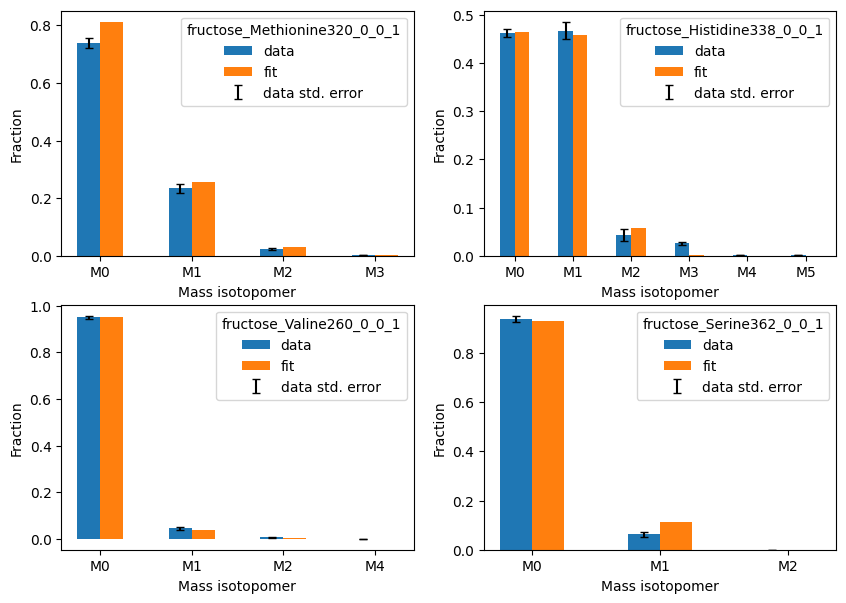

In [38]:
import matplotlib.pyplot as plt

fragments = ["fructose_Methionine320_0_0_1", "fructose_Histidine338_0_0_1", "fructose_Valine260_0_0_1", "fructose_Serine362_0_0_1"]
fig, axes = plt.subplots(2, 2, figsize=(10, 7))

for frag, ax in zip(fragments, axes.ravel()):
    visualization.plot_idv_barplot(res, frag, ax=ax)

It is clear that some of these estimates e.g. Histidine338 M3, fits the data quite poor. There are different ways of handling poor fitting measurements. It this case it it likely that the poor fit arise from mistake that we made when formulating the model or the data. Because this data comes from another research group, we may have missed some important details when reproducing the analysis. 

At the end we will shortly compare the our results the to results in figure 2 in the article. We will consider only the reactions around F6P as this is were the carbon which enters the cells is split between different metabolic pathways.

In [39]:
# view_reaction = estimates_from_article['Reactions'].values
fluxes_for_f6p = res.fitdata.fitted_parameters.query("type.str.contains('Net flux')").query("eqn.str.contains('F6P')")[['id', 'type', 'eqn', 'val', 'std', 'lb', 'ub']]

In [40]:
values_from_fig2 = {
    'FRU.ext -> F6P': 1,
    'F6P <-> G6P' : 1,
    'F16P -> F6P' : 1e-6,
    'E4P + X5P <-> F6P + G3P' : -0.008,
    'S7P + G3P <-> E4P + F6P' : 0.04
}
fluxes_for_f6p['literature_value'] = fluxes_for_f6p['eqn'].map(values_from_fig2)

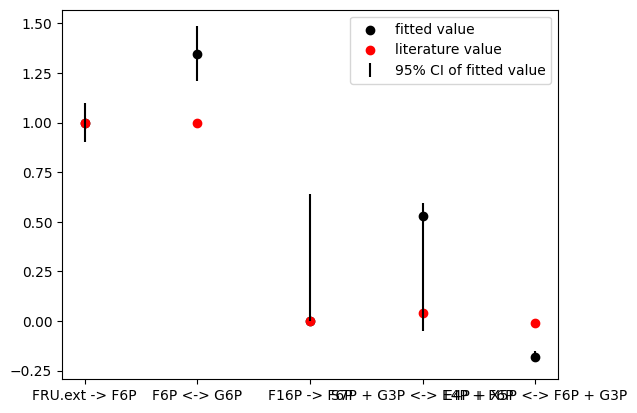

In [41]:
fig, ax = plt.subplots()
errbars = fluxes_for_f6p[['lb', 'ub']].subtract(fluxes_for_f6p['val'], axis=0).abs().T
ax.scatter(x=fluxes_for_f6p['eqn'], y=fluxes_for_f6p['val'], color='black', label='fitted value')
ax.errorbar(x=fluxes_for_f6p['eqn'], y=fluxes_for_f6p['val'], yerr=errbars, color='black', fmt='none', label='95% CI of fitted value')
ax.scatter(x=fluxes_for_f6p['eqn'], y=fluxes_for_f6p['literature_value'], color='red', label='literature value')
ax.legend()

Also, here we see that our analysis does not agree with the literature values. This is expected because our fit is worse than the fit report.

Even though we were not capable of reproducing the literature reports, we hope that this notebook can serve as a tutorial for how to use the incawrapper analyse data from 13C labelling experiments.